__Author: Стурейко Игорь__

__Project: Geekbrains.NeutralNets__

__Lesson 1 - Основы__

__Date: 2021-12-01__

# Импорты

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import cm
import matplotlib.pyplot as plt

import seaborn as sns

# Вспомогательные функции

In [2]:
# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized


# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        hot = Y[i]
        for j in range(len(hot)):
            if hot[j] == 1:
                arr[i] = j + 1
    return arr


def sigmoid(var):
    return 1 / (1 + np.exp(-var))

# Классы сети

## Сеть с двумя слоями

In [3]:
class TwoLayerNet:
    """
    Class for neutral net with two layers
    """

    def __init__(self, neuron_numb, steps, learning_rate):
        self.learning_rate = learning_rate
        self.steps = steps
        self.neuron_numb = neuron_numb
        self.w0 = (1, 1)
        self.w1 = (1, 1)
        self.fit_flag = False

    # сигмоида и ее производная
    @staticmethod
    def act_func(var):
        return 1 / (1 + np.exp(-var))

    @staticmethod
    def act_func_deriv(var):
        return var * (1 - var)

    def fit(self, X_train, y_train):
        self.fit_flag = True
        # присваевание случайных весов
        self.w0 = 2 * np.random.random((X_train.shape[1], self.neuron_numb)) - 1  # для входного слоя
        self.w1 = 2 * np.random.random((self.neuron_numb, y_train.shape[1])) - 1  # для внутреннего слоя

        # процесс обучения
        accuracy = 0
        for i in range(self.steps):
            # прямое распространение(feed forward)
            layer0 = X_train
            layer1 = self.act_func(np.dot(layer0, self.w0))
            layer2 = self.act_func(np.dot(layer1, self.w1))

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer2_error = y_train - layer2  # производная функции потерь = производная квадратичных потерь
            layer2_delta = layer2_error * self.act_func_deriv(layer2)

            layer1_error = layer2_delta.dot(self.w1.T)
            layer1_delta = layer1_error * self.act_func_deriv(layer1)
            # коррекция
            self.w1 += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w0 += layer0.T.dot(layer1_delta) * self.learning_rate
            # метрика модели
            error = np.mean(np.abs(layer2_error))
            accuracy = (1 - error) * 100

        return accuracy

    def predict(self, X_test, y_test):
        if self.fit_flag:
            # прямое распространение(feed forward)
            layer0_t = X_test
            layer1_t = self.act_func(np.dot(layer0_t, self.w0))
            layer2_t = self.act_func(np.dot(layer1_t, self.w1))
            layer2_error_t = y_test - layer2_t

            # метрика модели
            error_t = np.mean(np.abs(layer2_error_t))
            accuracy_t = (1 - error_t) * 100
        else:
            accuracy_t = None

        return accuracy_t

## Сеть с тремя слоями

In [40]:
class ThreeLayerNet:
    """
    Class for neutral net with three layers
    """

    def __init__(self, neuron_numb, steps, learning_rate):
        self.learning_rate = learning_rate
        self.steps = steps
        self.neuron_numb = neuron_numb
        self.w0 = (1, 1)
        self.w1 = (1, 1)
        self.w2 = (1, 1)
        self.fit_flag = False

    # сигмоида и ее производная
    @staticmethod
    def act_func(var):
        return 1 / (1 + np.exp(-var))

    @staticmethod
    def act_func_deriv(var):
        return var * (1 - var)

    def fit(self, X_train, y_train):
        self.fit_flag = True
        # присваевание случайных весов
        self.w0 = 2 * np.random.random((X_train.shape[1], self.neuron_numb)) - 1  # для входного слоя
        self.w1 = 2 * np.random.random((self.neuron_numb, self.neuron_numb)) - 1  # для внутреннего слоя
        self.w2 = 2 * np.random.random((self.neuron_numb, y_train.shape[1])) - 1  # для крайнего слоя

        # процесс обучения
        accuracy = 0
        for i in range(self.steps):
            # прямое распространение(feed forward)
            layer0 = X_train
            layer1 = self.act_func(np.dot(layer0, self.w0))
            layer2 = self.act_func(np.dot(layer1, self.w1))
            layer3 = self.act_func(np.dot(layer2, self.w2))

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer3_error = y_train - layer3  # производная функции потерь = производная квадратичных потерь
            layer3_delta = layer3_error * self.act_func_deriv(layer3)
            
            layer2_error = layer3_delta.dot(self.w2.T)
            layer2_delta = layer2_error * self.act_func_deriv(layer2)

            layer1_error = layer2_delta.dot(self.w1.T)
            layer1_delta = layer1_error * self.act_func_deriv(layer1)
            
            # коррекция
            self.w2 += layer2.T.dot(layer3_delta) * self.learning_rate
            self.w1 += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w0 += layer0.T.dot(layer1_delta) * self.learning_rate
            
            # метрика модели
            error = np.mean(np.abs(layer3_error))
            accuracy = (1 - error) * 100

        return accuracy

    def predict(self, X_test, y_test):
        if self.fit_flag:
            # прямое распространение(feed forward)
            layer0_t = X_test
            layer1_t = self.act_func(np.dot(layer0_t, self.w0))
            layer2_t = self.act_func(np.dot(layer1_t, self.w1))
            layer3_t = self.act_func(np.dot(layer2_t, self.w2))
            layer3_error_t = y_test - layer3_t

            # метрика модели
            error_t = np.mean(np.abs(layer3_error_t))
            accuracy_t = (1 - error_t) * 100
        else:
            accuracy_t = None

        return accuracy_t

# Подготовка тренировочных данных

In [43]:

# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# Расчет сети

## Расчет сети на 2 слоя

In [44]:
net = TwoLayerNet(5, 1000, 0.05)
acc_train = net.fit(X_train, y_train)
print(f"Точность сети на трейне {acc_train}")

Точность сети на трейне 90.23332880285507


## Расчет сети на 3 слоя

In [45]:
net = ThreeLayerNet(5, 1000, 0.05)
acc_train = net.fit(X_train, y_train)
print(f"Точность сети на трейне {acc_train}")

Точность сети на трейне 92.9075088631859


# Влияние параметров на точность сети

## Влияние числа эпох и скорости обучения

### Сеть на два слоя

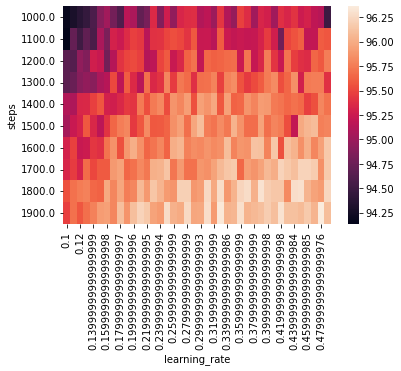

In [37]:
res = pd.DataFrame(columns=['steps', 'learning_rate', 'accurancy'])
num_neurons = 10
for learning_rate in np.arange(0.1, 0.5, 0.01):
    for steps in np.arange(1000, 2000, 100):
        net = TwoLayerNet(num_neurons, steps, learning_rate)
        acc_train = net.fit(X_train, y_train)
        res.loc[len(res)] = [steps, learning_rate, acc_train]

to_heat = res.pivot('steps', 'learning_rate', 'accurancy')
ax = sns.heatmap(to_heat)

### Сеть на 3 слоя

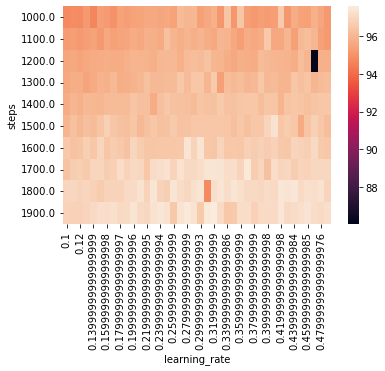

In [46]:
res = pd.DataFrame(columns=['steps', 'learning_rate', 'accurancy'])
num_neurons = 10
for learning_rate in np.arange(0.1, 0.5, 0.01):
    for steps in np.arange(1000, 2000, 100):
        net = ThreeLayerNet(num_neurons, steps, learning_rate)
        acc_train = net.fit(X_train, y_train)
        res.loc[len(res)] = [steps, learning_rate, acc_train]

to_heat = res.pivot('steps', 'learning_rate', 'accurancy')
ax = sns.heatmap(to_heat)

## Влияние числа нейронов в слое и скорости обучения

### Сеть на два слоя

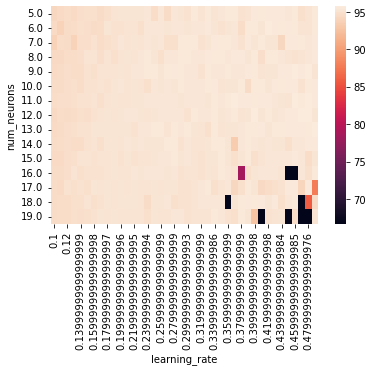

In [49]:
res = pd.DataFrame(columns=['num_neurons', 'learning_rate', 'accurancy'])
steps = 1000
for learning_rate in np.arange(0.1, 0.5, 0.01):
    for num_neurons in np.arange(5, 20, 1):
        net = TwoLayerNet(num_neurons, steps, learning_rate)
        acc_train = net.fit(X_train, y_train)
        res.loc[len(res)] = [num_neurons, learning_rate, acc_train]

to_heat = res.pivot('num_neurons', 'learning_rate', 'accurancy')
ax = sns.heatmap(to_heat)

### Сеть на 3 слоя

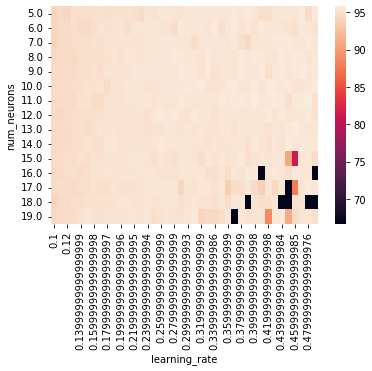

In [48]:
res = pd.DataFrame(columns=['num_neurons', 'learning_rate', 'accurancy'])
steps = 1000
for learning_rate in np.arange(0.1, 0.5, 0.01):
    for num_neurons in np.arange(5, 20, 1):
        net = TwoLayerNet(num_neurons, steps, learning_rate)
        acc_train = net.fit(X_train, y_train)
        res.loc[len(res)] = [num_neurons, learning_rate, acc_train]

to_heat = res.pivot('num_neurons', 'learning_rate', 'accurancy')
ax = sns.heatmap(to_heat)